### Investigating ghost coherence

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [158]:
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from tqdm import tqdm

from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.util import _extract_roi

#### Spectral analysis parameters

In [3]:
# Smoothing windows
sm_times = 0.3  # In seconds
sm_freqs = 1
sm_kernel = "square"

# Defining parameters
decim = 20  # Downsampling factor
mode = "multitaper"  # Wheter to use Morlet or Multitaper

n_freqs = 60  # How many frequencies to use
freqs = np.linspace(3, 75, n_freqs)  # Frequency array
n_cycles = freqs / 4  # Number of cycles
mt_bandwidth = None


def return_evt_dt(align_at):
    """Return the window in which the data will be loaded
    depending on the alignment"""
    assert align_at in ["cue", "match"]
    if align_at == "cue":
        return [-0.65, 3.00]
    else:
        return [-2.2, 0.65]

#### Loading data

In [4]:
# Instantiate class
ses = session(
    raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
    monkey="lucy",
    date="141024",
    session=1,
    slvr_msmod=False,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
)

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1], behavioral_response=[1])

In [5]:
#### Surrogate data
n_surr = 1
data_surr = []
for i in range(n_surr):
    data_surr += [trial_swap_surrogates(data, seed=i + 500, verbose=False)]

In [6]:
band = slice(26, 43)

### Channels with large beta power

- F2 (36)
- F1 (63, 69, 73, 83, 84, 92, 95, 105)
- a3 (64, 65, 66, 106, 107)

In [7]:
channels = np.array([36, 63, 69, 73, 83, 84, 92, 95, 105, 64, 65, 66, 106, 107])
idx = [(ch in channels) for ch in data.channels_labels]

#### Trial-averaged spectogram

In [8]:
w = _tf_decomp(
    data,
    data.attrs["fsample"],
    freqs,
    mode=mode,
    n_cycles=n_cycles,
    mt_bandwidth=None,
    decim=decim,
    kw_cwt={},
    kw_mt={},
    n_jobs=20,
)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   41.3s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   54.7s remaining:    2.2s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   55.6s finished


In [9]:
w = xr.DataArray(
    (w * np.conj(w)).real,
    name="power",
    dims=("trials", "roi", "freqs", "times"),
    coords=(data.trials.values, data.roi.values, freqs, data.time.values[::decim]),
)

In [10]:
# Select ROIs
w_sel = w.isel(roi=idx)

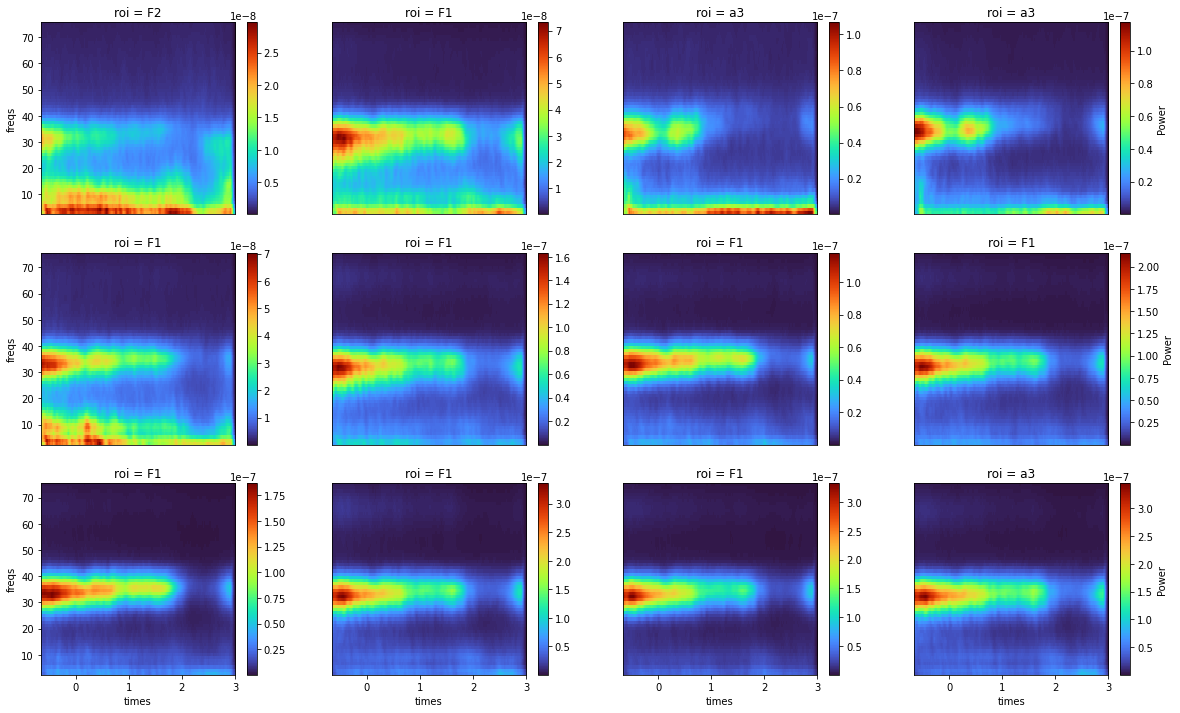

In [11]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    plt.subplot(3, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial power

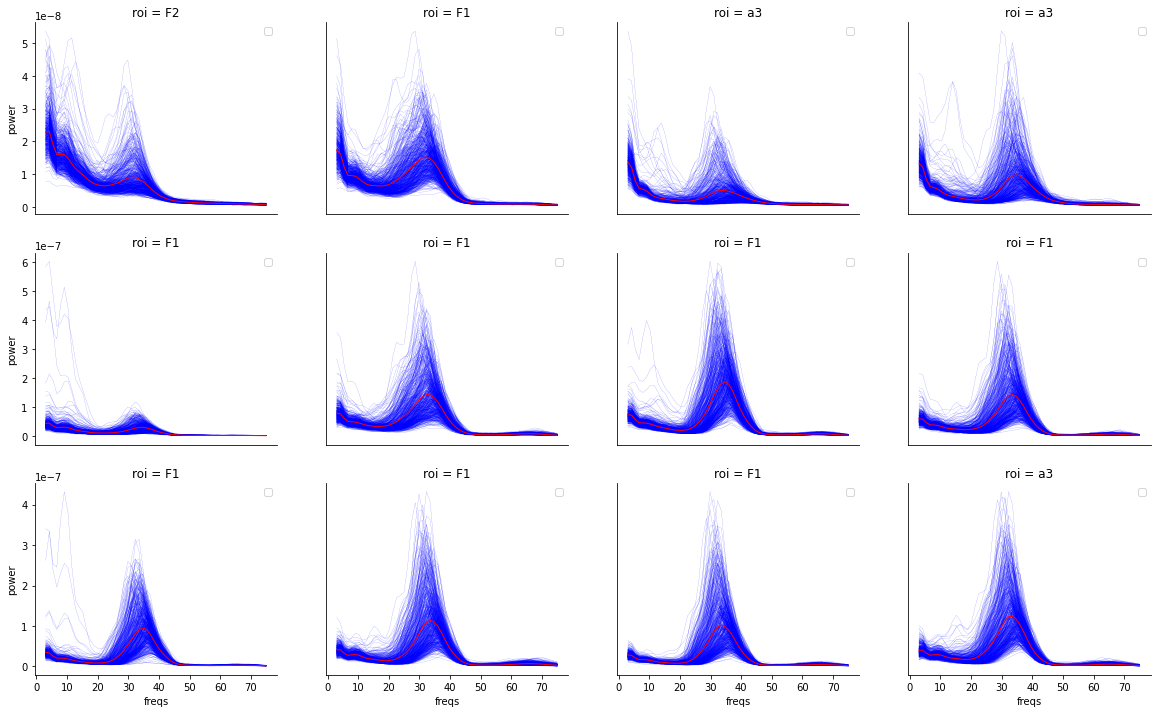

In [12]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific power time-series at single trial

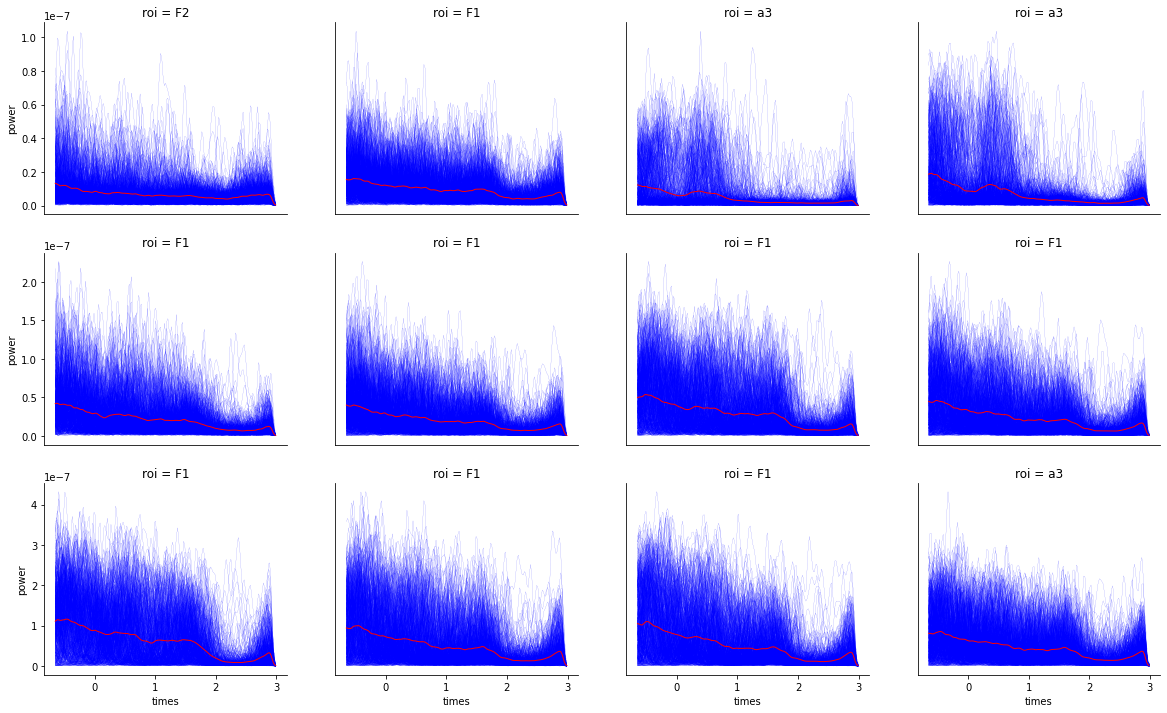

In [13]:
out = w_sel.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

### Ghost-coherence with V1 (236)

- 36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117

#### Trial-averaged spectogram

In [14]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
idx = [(ch in channels) for ch in data.channels_labels]

In [15]:
w_sel = w.isel(roi=idx)

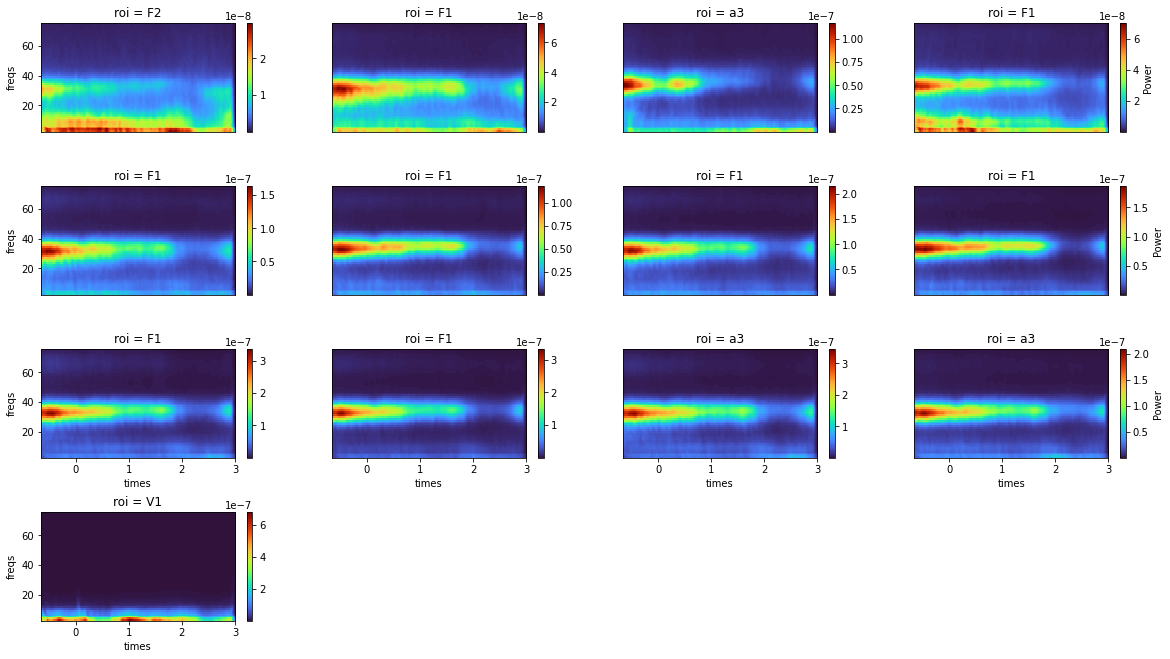

In [16]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 14))
for i in range(n_rois):
    plt.subplot(5, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
plt.subplots_adjust(hspace=0.5)

#### Time-averaged single trial power

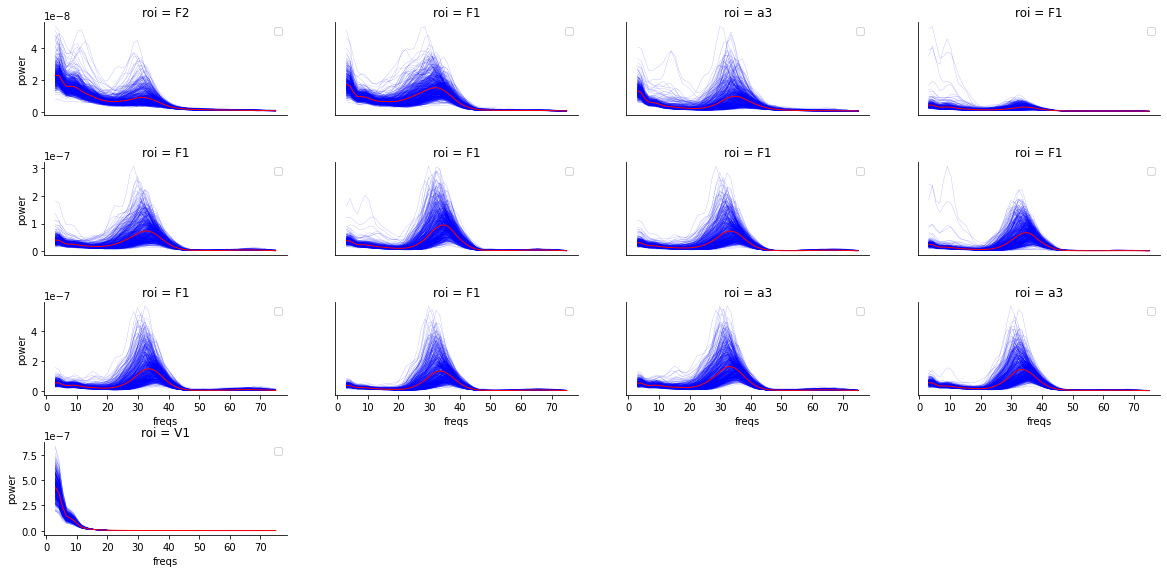

In [17]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

#### Band-specific power time-series at single trial

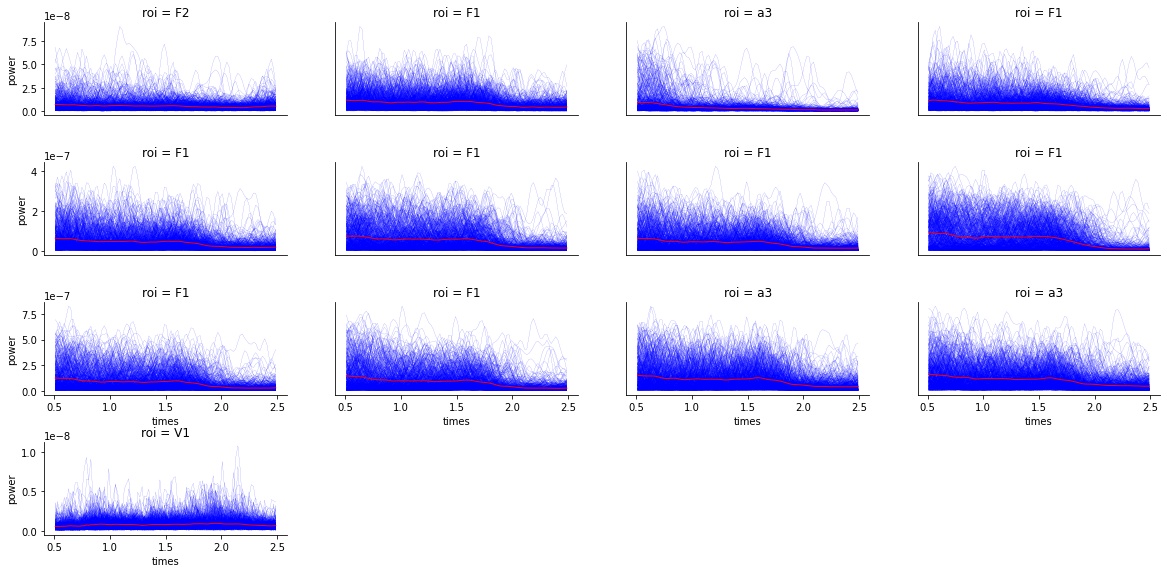

In [18]:
out = w_sel.sel(freqs=band).mean("freqs").sel(times=slice(0.5, 2.5))

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

#### Spectral-content and spectral entropy (whole task)

In [19]:
S = w_sel.mean("times")  # Compute statical spectra
areas = S.roi.values

In [20]:
#  ROIs with channel numbers
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
rois = [f"{area} ({channel})" for area, channel in zip(S.roi.values, channels)]

In [21]:
S_tilda = S / S.integrate(coord="freqs")  # Normalize spectra
S_tilda = S_tilda.assign_coords({"roi": rois})

In [22]:
SC = S_tilda.sel(freqs=band).integrate(coord="freqs")  # Spectral content in beta band
H_max = np.log(S_tilda.sel(freqs=band).sizes["freqs"])  # Maximum spectral entropy
SE = -(S_tilda * np.log(S_tilda)).sel(freqs=band).sum("freqs") / H_max
Q = S_tilda.sel(freqs=band).max("freqs") / S_tilda.max("freqs")

In [23]:
custom_palette = sns.color_palette("pastel", 2 * len(np.unique(areas)))
colors = []
for r in S_tilda.roi.values:
    if r[:2] == "F1":
        colors += [custom_palette[0]]
    elif r[:2] == "F2":
        colors += [custom_palette[2]]
    elif r[:3] == "a3":
        colors += [custom_palette[3]]
    else:
        colors += [custom_palette[6]]
colors = dict(zip(S_tilda.roi.values, colors))

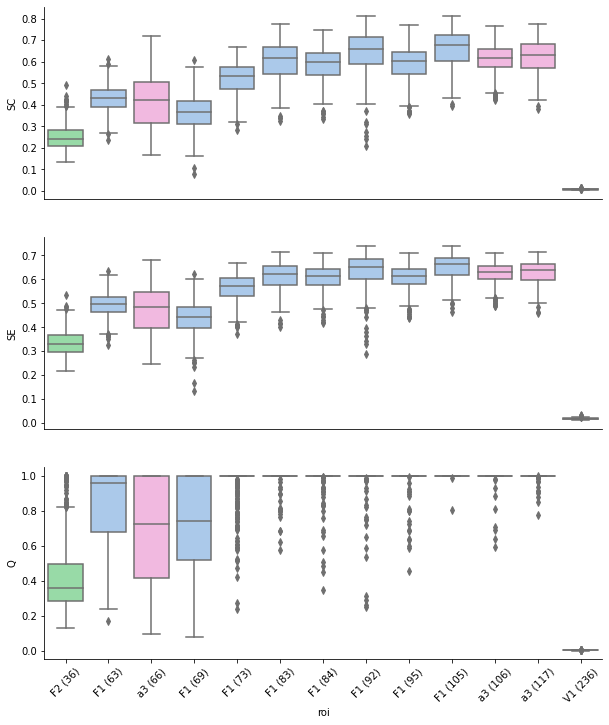

In [24]:
plt.figure(figsize=(10, 12))
ax = plt.subplot(311)
df = SC.to_dataframe(name="SC").reset_index()
sns.boxplot(x=df["roi"], y=df["SC"], palette=colors)
plt.xticks([])
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = plt.subplot(312)
df = SE.to_dataframe(name="SE").reset_index()
sns.boxplot(x=df["roi"], y=df["SE"], palette=colors)
plt.xticks([])
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = plt.subplot(313)
df = Q.to_dataframe(name="Q").reset_index()
sns.boxplot(x=df["roi"], y=df["Q"], palette=colors)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks(rotation=45);

#### Spectral-content and spectral entropy (windowed)

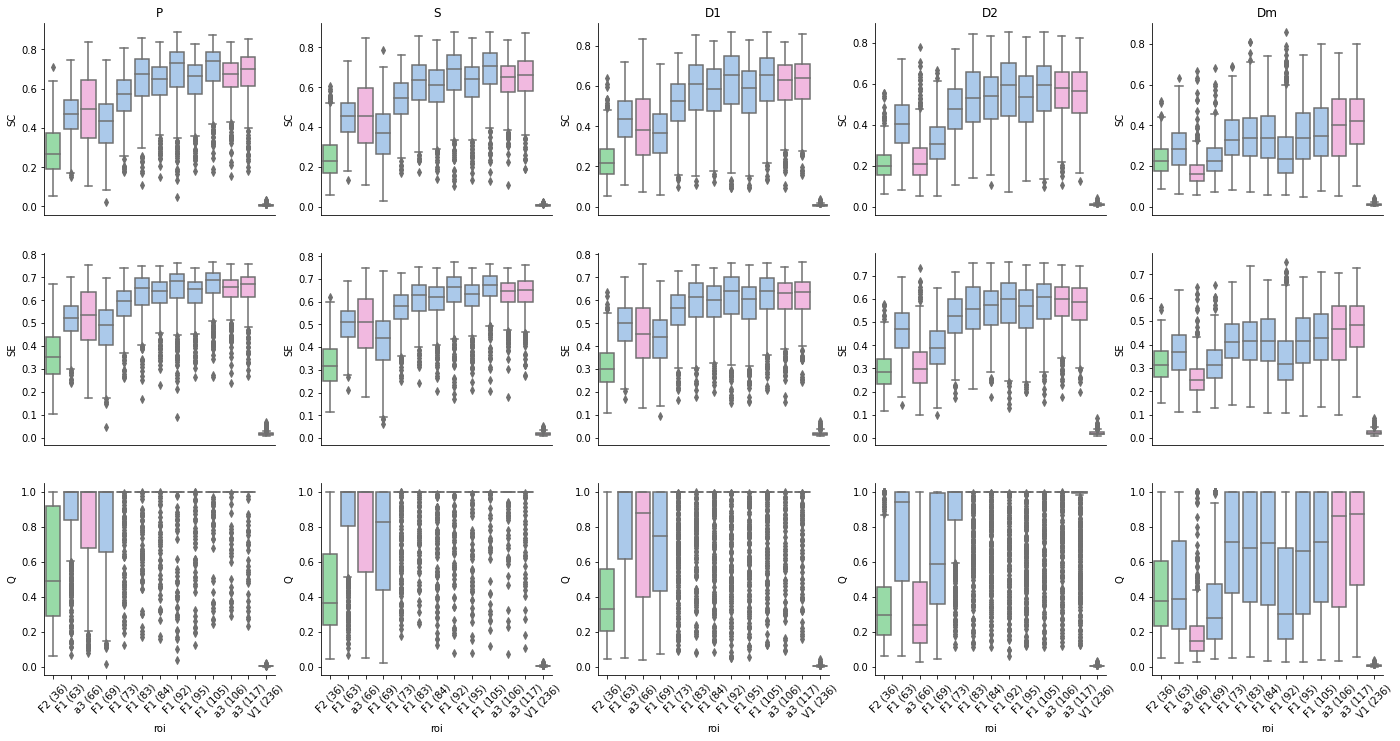

In [25]:
t_win = np.array([[-0.5, 0], [0, 0.5], [0.5, 1.0], [1.5, 2.0], [2.0, 2.5]])

#  ROIs with channel numbers
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
areas = w_sel.roi.values
rois = [f"{area} ({channel})" for area, channel in zip(w_sel.roi.values, channels)]

custom_palette = sns.color_palette("pastel", 2 * len(np.unique(areas)))

colors = []
for r in S_tilda.roi.values:
    if r[:2] == "F1":
        colors += [custom_palette[0]]
    elif r[:2] == "F2":
        colors += [custom_palette[2]]
    elif r[:3] == "a3":
        colors += [custom_palette[3]]
    else:
        colors += [custom_palette[6]]
colors = dict(zip(S_tilda.roi.values, colors))


def set_axis(count, n_col):
    if count not in range(11, 16):
        plt.xticks([])
        plt.xlabel("")
    else:
        plt.xticks(rotation=45)


plt.figure(figsize=(24, 12))

pos = np.arange(1, 16, dtype=int).reshape(3, len(t_win))
pos = pos.T.flatten()
count = 0
titles = ["P", "S", "D1", "D2", "Dm"]

for t0, t1 in t_win:

    # Compute spectra in window of interest
    S = w_sel.sel(times=slice(t0, t1)).mean("times")
    # Normalize spectra
    S_tilda = S / S.integrate(coord="freqs")
    S_tilda = S_tilda.assign_coords({"roi": rois})
    # Spectral content in beta band
    SC = S_tilda.sel(freqs=band).integrate(coord="freqs")
    # Maximum spectral entropy in beta band
    H_max = np.log(S_tilda.sel(freqs=band).sizes["freqs"])
    # Normalized spectral entropy in beta band
    SE = -(S_tilda * np.log(S_tilda)).sel(freqs=band).sum("freqs") / H_max
    # Peak prominence
    Q = S_tilda.sel(freqs=band).max("freqs") / S_tilda.max("freqs")

    ax = plt.subplot(3, len(t_win), pos[count])
    df = SC.to_dataframe(name="SC").reset_index()
    sns.boxplot(x=df["roi"], y=df["SC"], palette=colors)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    set_axis(pos[count], 3)

    plt.title(titles[pos[count] - 1])

    count += 1
    ax = plt.subplot(3, len(t_win), pos[count])
    df = SE.to_dataframe(name="SE").reset_index()
    sns.boxplot(x=df["roi"], y=df["SE"], palette=colors)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    set_axis(pos[count], 3)
    count += 1

    ax = plt.subplot(3, len(t_win), pos[count])
    df = Q.to_dataframe(name="Q").reset_index()
    sns.boxplot(x=df["roi"], y=df["Q"], palette=colors)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    set_axis(pos[count], 3)
    count += 1

### Computing coherence with V1 (236)

In [26]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117])
channel_v1 = np.array([236] * len(channels))

idx_s, idx_t = [], []

for ch in channels:
    if ch in data.channels_labels:
        idx_s.append(np.where(ch == data.channels_labels)[0][0])


for ch in channel_v1:
    if ch in data.channels_labels:
        idx_t.append(np.where(ch == data.channels_labels)[0][0])

In [27]:
pairs = np.vstack((idx_s, idx_t)).T

In [28]:
kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=pairs,
    sfreq=ses.data.attrs["fsample"],
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
    metric="coh",
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    sm_kernel=sm_kernel,
    block_size=2,
)

# compute the coherence
coh = conn_spec(data, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=12, n_freqs=60, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   20.6s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   26.9s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   27.4s finished
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/12 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.0s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   28.3s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   28.8s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/12 [00:00<?,       ?it/s]

In [29]:
#### Surrogate data
data_surr = trial_swap_surrogates(data, seed=123456, verbose=False)

In [30]:
# compute the coherence
coh_surr = conn_spec(data_surr, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=12, n_freqs=60, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.5s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   29.0s remaining:    1.2s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   29.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/12 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   23.2s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   29.5s remaining:    1.2s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   30.0s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/12 [00:00<?,       ?it/s]

In [31]:
coh = np.clip(coh - coh_surr.quantile(0.95, "trials"), 0, np.inf)

#### Trial-averaged time-frequency coherence

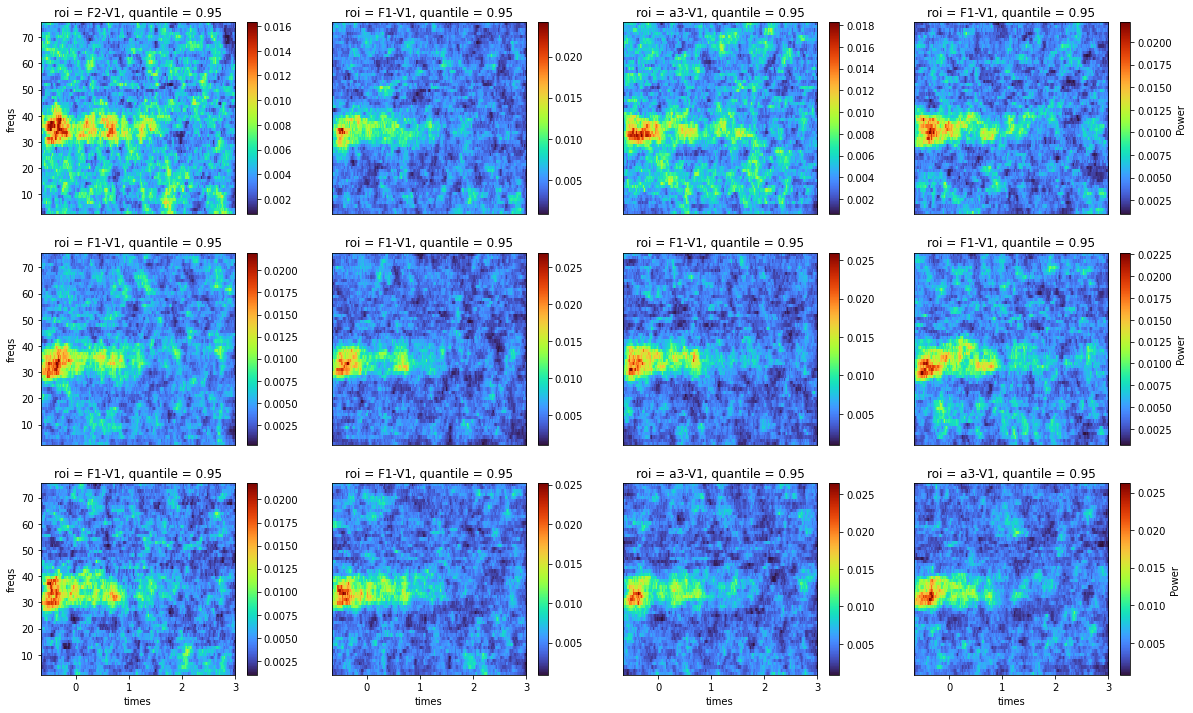

In [32]:
# Get number of ROIs
n_rois = coh.sizes["roi"]

out = coh.mean("trials")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    plt.subplot(3, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial coherence

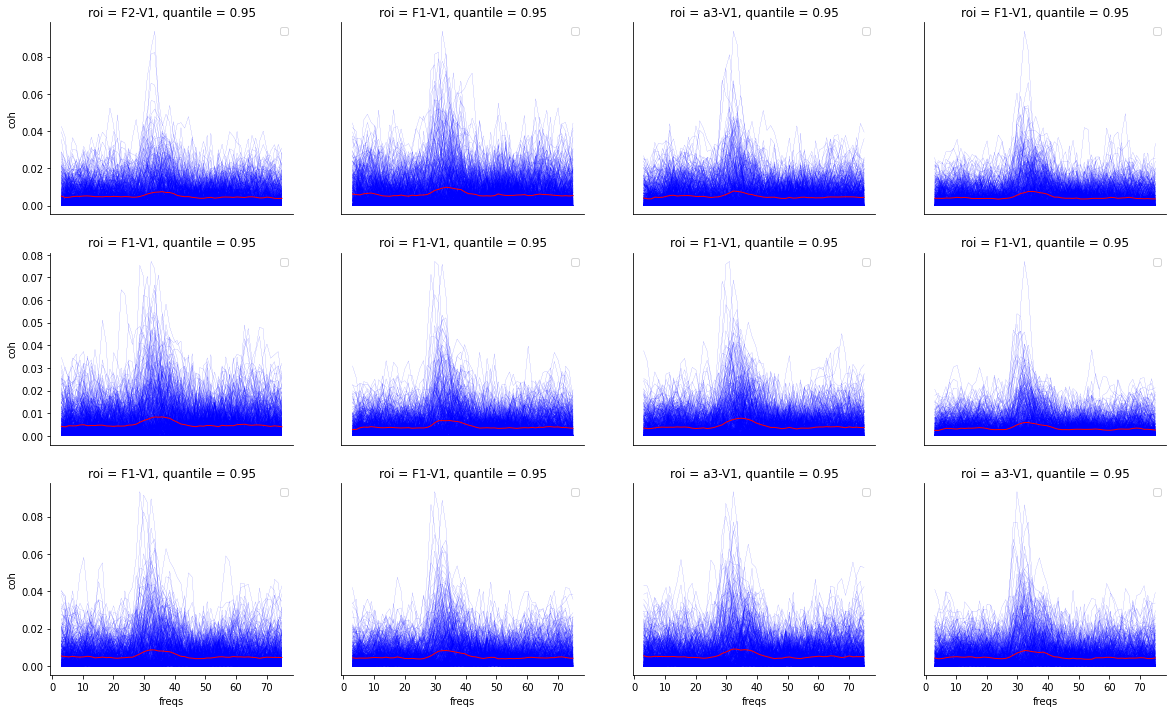

In [33]:
out = coh.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific coherence time-series at single trial

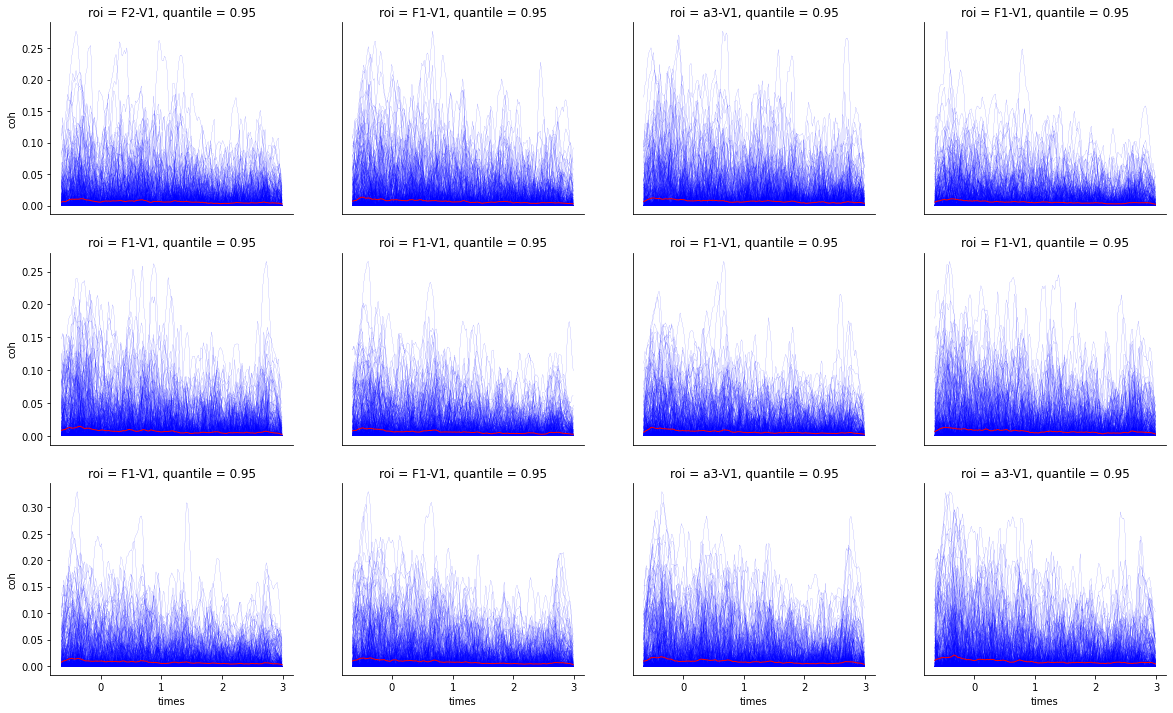

In [34]:
out = coh.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Coherence-content and coherence entropy (whole task)

In [35]:
C = coh.mean("times")  # Compute statical spectra
areas = coh.roi.values
channels = np.vstack((channels, channel_v1))

rois = [
    f"{edge[:2]} ({ch_s})-{edge[3:]} ({ch_t})"
    for edge, ch_s, ch_t in np.vstack((areas, channels)).T
]

In [36]:
channels = np.vstack((channels, channel_v1))

In [37]:
C_tilda = C / C.integrate(coord="freqs")  # Normalize coherence
C_tilda = C_tilda.assign_coords({"roi": rois})

In [38]:
SC = C_tilda.sel(freqs=band).integrate(coord="freqs")  # Spectral content in beta band
H_max = np.log(C_tilda.sel(freqs=band).sizes["freqs"])  # Maximum spectral entropy
SE = -(C_tilda * np.log(C_tilda)).sel(freqs=band).sum("freqs") / H_max
Q = C_tilda.sel(freqs=band).max("freqs") / C_tilda.max("freqs")

/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [39]:
custom_palette = sns.color_palette("pastel", 2 * len(np.unique(areas)))
colors = []
for r in C.roi.values:
    if r == "F1-V1":
        colors += [custom_palette[0]]
    elif r == "F2-V1":
        colors += [custom_palette[2]]
    elif r == "a3-V1":
        colors += [custom_palette[3]]
    else:
        colors += [custom_palette[4]]
colors = dict(zip(C_tilda.roi.values, colors))

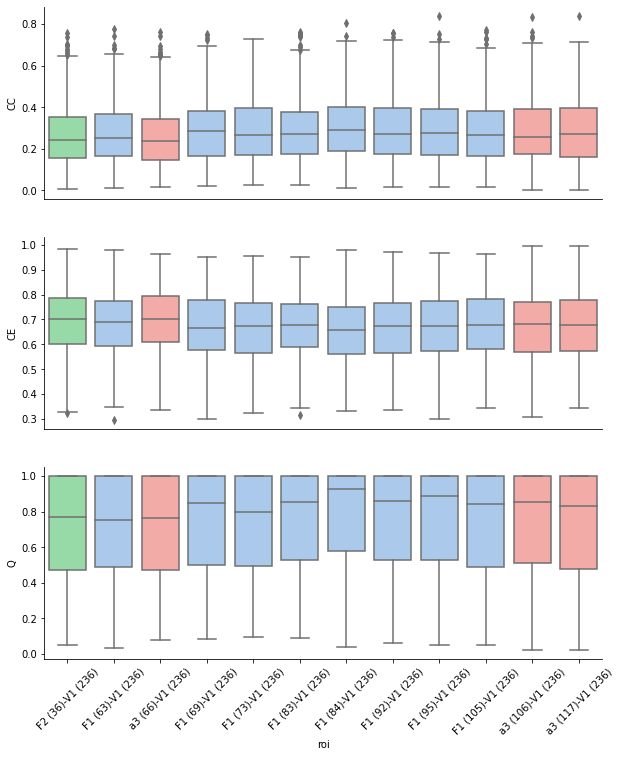

In [40]:
plt.figure(figsize=(10, 12))
ax = plt.subplot(311)
df = SC.to_dataframe(name="CC").reset_index()
sns.boxplot(x=df["roi"], y=df["CC"], palette=colors)
plt.xticks([])
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = plt.subplot(312)
df = SE.to_dataframe(name="CE").reset_index()
sns.boxplot(x=df["roi"], y=1 - df["CE"], palette=colors)
plt.xticks([])
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = plt.subplot(313)
df = Q.to_dataframe(name="Q").reset_index()
sns.boxplot(x=df["roi"], y=df["Q"], palette=colors)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks(rotation=45);

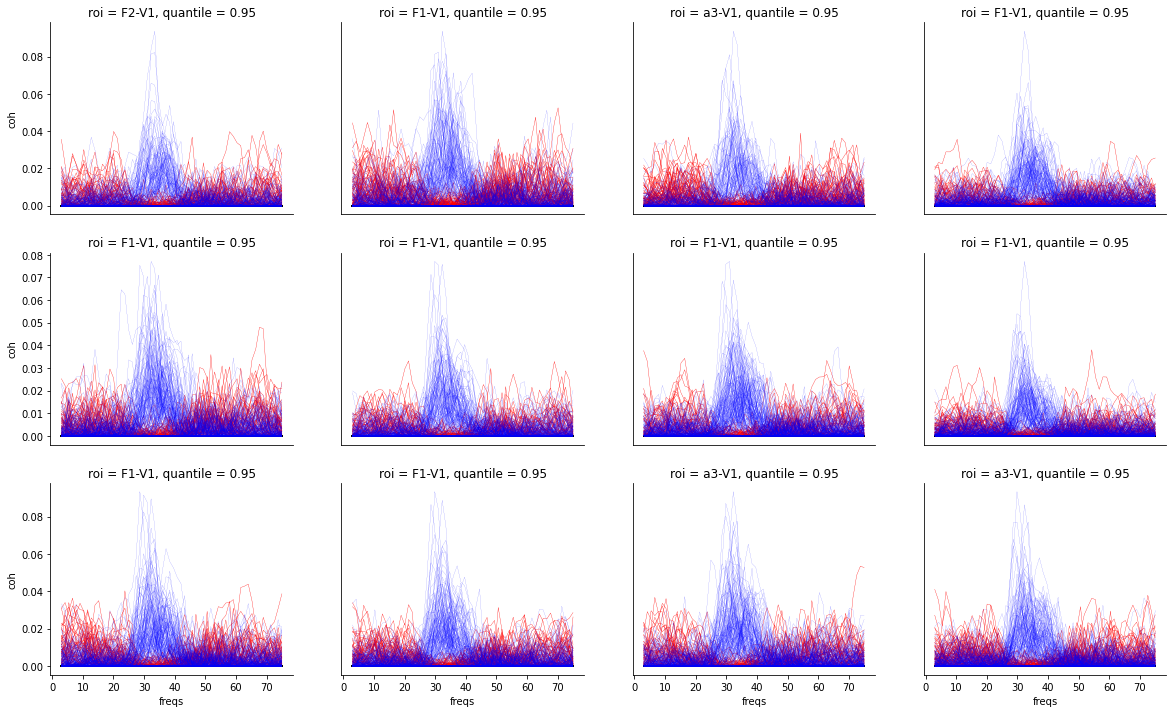

In [41]:
out1 = C * (SC.assign_coords({"roi": areas}) < 0.1)
out2 = C * (SC.assign_coords({"roi": areas}) > 0.4)

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out1.isel(roi=i).plot(x="freqs", hue="trials", lw=0.3, c="r")
    out2.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:

        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Coherence-content and coherence entropy (windowed)

/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


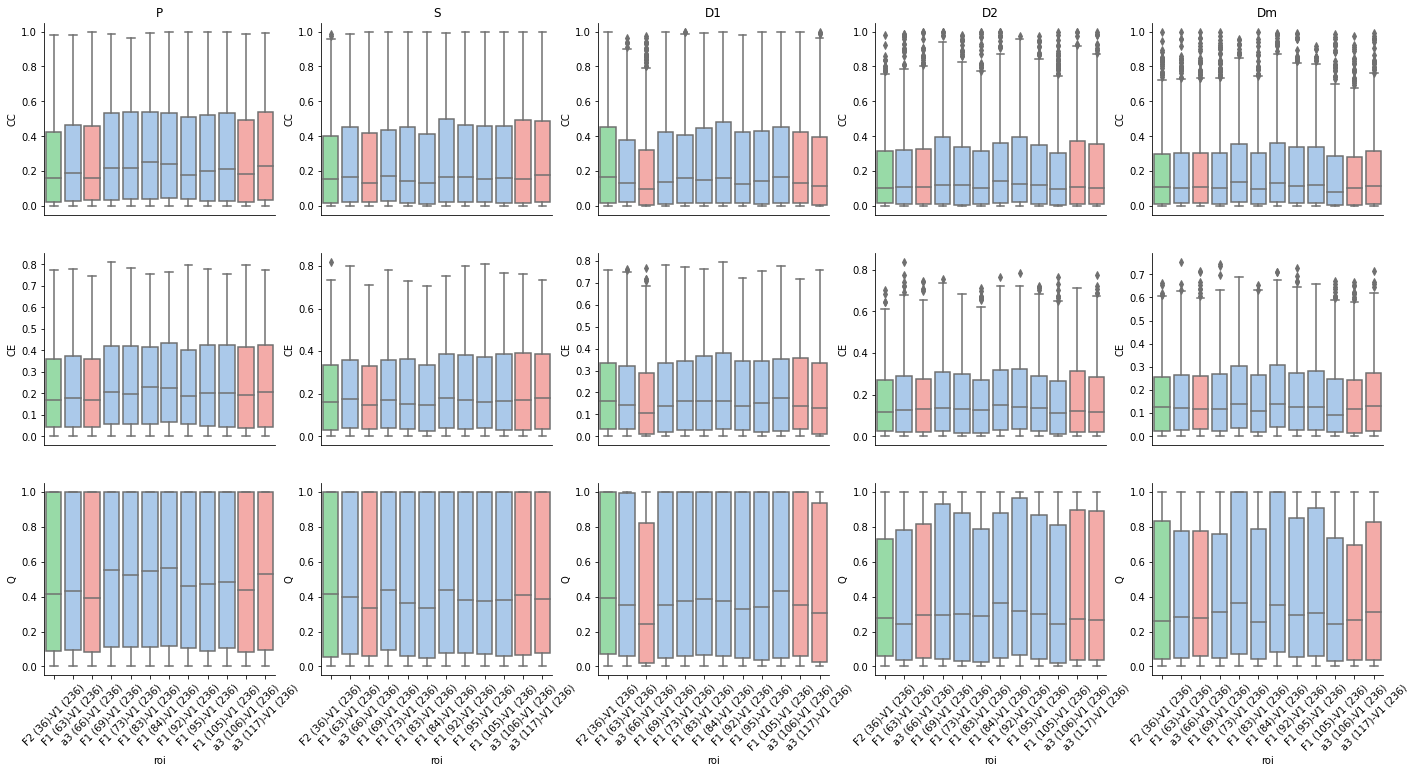

In [42]:
t_win = np.array([[-0.5, 0], [0, 0.5], [0.5, 1.0], [1.5, 2.0], [2.0, 2.5]])

#  ROIs with channel numbers
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
areas = coh.roi.values

custom_palette = sns.color_palette("pastel", 2 * len(np.unique(areas)))
colors = []
for r in C.roi.values:
    if r == "F1-V1":
        colors += [custom_palette[0]]
    elif r == "F2-V1":
        colors += [custom_palette[2]]
    elif r == "a3-V1":
        colors += [custom_palette[3]]
    else:
        colors += [custom_palette[4]]
colors = dict(zip(C_tilda.roi.values, colors))


def set_axis(count, n_col):
    if count not in range(11, 16):
        plt.xticks([])
        plt.xlabel("")
    else:
        plt.xticks(rotation=45)


plt.figure(figsize=(24, 12))

pos = np.arange(1, 16, dtype=int).reshape(3, len(t_win))
pos = pos.T.flatten()
count = 0
titles = ["P", "S", "D1", "D2", "Dm"]

for t0, t1 in t_win:

    # Compute spectra in window of interest
    C = coh.sel(times=slice(t0, t1)).mean("times")
    # Normalize spectra
    C_tilda = C / C.integrate(coord="freqs")
    C_tilda = C_tilda.assign_coords({"roi": rois})
    # Spectral content in beta band
    SC = C_tilda.sel(freqs=band).integrate(coord="freqs")
    # Maximum spectral entropy in beta band
    H_max = np.log(C_tilda.sel(freqs=band).sizes["freqs"])
    # Normalized spectral entropy in beta band
    SE = -(C_tilda * np.log(C_tilda)).sel(freqs=band).sum("freqs") / H_max
    # Peak prominence
    Q = C_tilda.sel(freqs=band).max("freqs") / C_tilda.max("freqs")

    ax = plt.subplot(3, len(t_win), pos[count])
    df = SC.to_dataframe(name="CC").reset_index()
    sns.boxplot(x=df["roi"], y=df["CC"], palette=colors)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    set_axis(pos[count], 3)

    plt.title(titles[pos[count] - 1])

    count += 1
    ax = plt.subplot(3, len(t_win), pos[count])
    df = SE.to_dataframe(name="CE").reset_index()
    sns.boxplot(x=df["roi"], y=df["CE"], palette=colors)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    set_axis(pos[count], 3)
    count += 1

    ax = plt.subplot(3, len(t_win), pos[count])
    df = Q.to_dataframe(name="Q").reset_index()
    sns.boxplot(x=df["roi"], y=df["Q"], palette=colors)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    set_axis(pos[count], 3)
    count += 1

### Spatial distribution of spectral content (whole trial)

In [207]:
rois = [
    f"{area} ({channel})" for area, channel in zip(w.roi.values, data.channels_labels)
]

In [208]:
w_static = w.mean("times")

In [209]:
S_tilda = w_static / w_static.integrate(coord="freqs")  # Normalize spectra
S_tilda = S_tilda.assign_coords({"roi": rois})

In [210]:
SC = S_tilda.sel(freqs=band).integrate(coord="freqs")  # Spectral content in beta band

In [211]:
df = SC.to_dataframe(name="SC").reset_index()
df = df.sort_values("SC", ascending=False)

In [212]:
_, rois = _extract_roi(df.roi.values, ' ')

In [213]:
unique_rois = np.unique(rois)
custom_palette = sns.color_palette("pastel", len(unique_rois))

colors = [(0, 0, 0)] * len(rois)
for i_r_u, r_u in enumerate(unique_rois):
    for i_r, r in enumerate(rois):
        if r == r_u:
            colors[i_r] = custom_palette[i_r_u]
colors = dict(zip(df.roi.values, colors))

Text(0.5, 1.0, 'Ranked spectral content (26-43 Hz)')

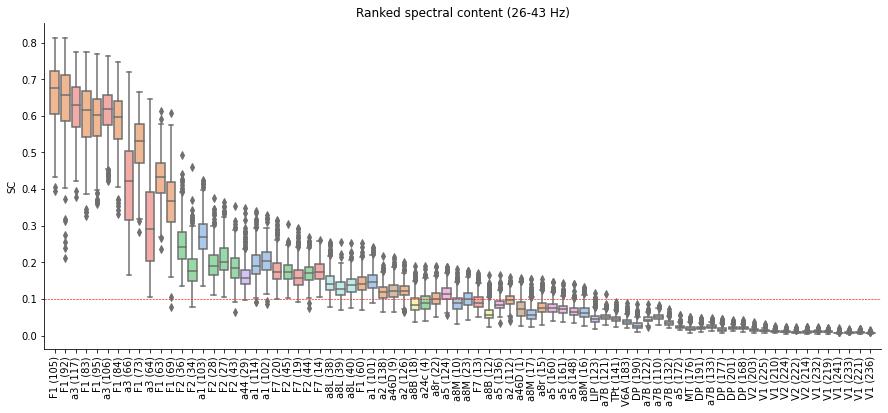

In [214]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(111)
sns.boxplot(x=df["roi"], y=df["SC"], palette=colors)
plt.xticks(rotation=90)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1, -1, SC.sizes["roi"], color="r", ls="--", lw=0.6)
plt.xlim(-1, SC.sizes["roi"])
plt.title("Ranked spectral content (26-43 Hz)")

### Overlap of beta and gamma bands

In [215]:
beta = slice(26, 43)
gamma = slice(43, 80)

In [216]:
rois = [
    f"{area} ({channel})" for area, channel in zip(w.roi.values, data.channels_labels)
]

In [217]:
w_beta = w.sel(freqs=beta).mean('freqs')
w_gamma = w.sel(freqs=gamma).mean('freqs')

In [218]:
z_beta = (w_beta - w_beta.mean('times')) / w_beta.std('times')
z_gamma = (w_gamma - w_gamma.mean('times')) / w_gamma.std('times')

In [219]:
cc = (z_beta * z_gamma).mean('times')
cc = cc.assign_coords({"roi": rois})

In [220]:
df = cc.to_dataframe(name='cc').reset_index()
df = df.sort_values("cc", ascending=False)

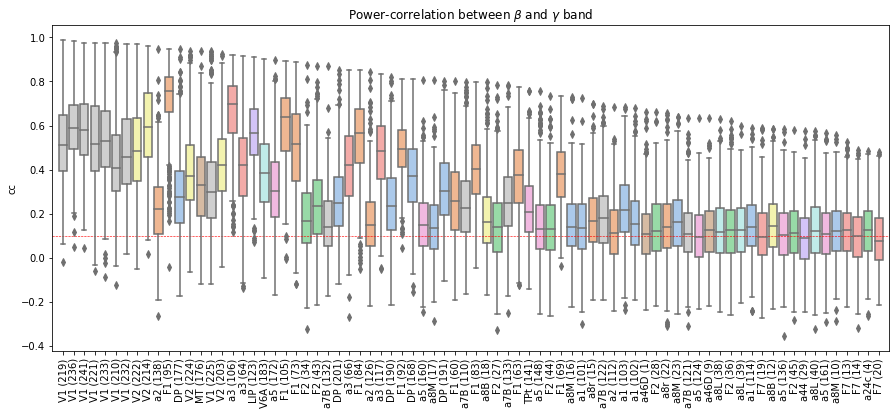

In [222]:
plt.figure(figsize=(15, 6))

sns.boxplot(x=df["roi"], y=df["cc"], palette=colors)
plt.xticks(rotation=90)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1, -1, SC.sizes["roi"], color="r", ls="--", lw=0.6)
plt.xlim(-1, SC.sizes["roi"])
plt.title(r"Power-correlation between $\beta$ and $\gamma$ band");